In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

### IMPORT

In [63]:
cnx = create_engine('postgresql://ubuntu@3.17.36.205/teamfight_tactics')

In [ ]:
# warning: this takes a while to execute
plat_df = pd.read_sql("SELECT * FROM platinum", cnx)
diamond_df = pd.read_sql("SELECT * FROM diamond", cnx)
master_df = pd.read_sql("SELECT * FROM master", cnx)
gmaster_df = pd.read_sql("SELECT * FROM grandmaster", cnx)
challenger_df = pd.read_sql("SELECT * FROM challenger", cnx)

In [ ]:
tft_df = pd.concat([plat_df, diamond_df, master_df, gmaster_df, challenger_df])

In [ ]:
tft_df.set_index('index', inplace=True)

In [ ]:
tft_df.info(verbose=True, null_counts=True)

In [ ]:
# tft_df.to_csv('tft_high_elo.csv')

### EDA

In [3]:
import seaborn as sns

In [4]:
# import csv if you don't want to go through SQLAlchemy again
tft_df = pd.read_csv('tft_high_elo.csv')

In [5]:
tft_df.set_index('index', inplace=True)

In [6]:
# tft_df.info(verbose=True, null_counts=True)

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# fig, ax = plt.subplots(figsize=(100,100))
# sns.heatmap(tft_df.drop(['lastround', 
#                              'ingameduration', 
#                              'blaster', 'chrono', 'cybernetic', 'darkstar', 'demolitionist',
#                             'infiltrator', 'manareaver', 'mechpilot', 'mercenary', 'protector',
#                             'rebel', 'set3_blademaster', 'set3_brawler', 'set3_celestial',
#                             'set3_mystic', 'set3_sorcerer', 'set3_void', 'sniper', 'spacepirate',
#                             'starguardian', 'starship', 'valkyrie', 'vanguard'], axis=1).corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

### Testing

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, fbeta_score, \
precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split

In [9]:
tft_sample = tft_df.drop(['lastround', 
                             'ingameduration', 
                             'blaster', 'chrono', 'cybernetic', 'darkstar', 'demolitionist',
                            'infiltrator', 'manareaver', 'mechpilot', 'mercenary', 'protector',
                            'rebel', 'set3_blademaster', 'set3_brawler', 'set3_celestial',
                            'set3_mystic', 'set3_sorcerer', 'set3_void', 'sniper', 'spacepirate',
                            'starguardian', 'starship', 'valkyrie', 'vanguard'], axis=1)#.sample(100000)

In [10]:
tft_sample['ranked'].replace({'Win': 1, 'Lose': 0}, inplace=True)

In [11]:
tft_sample['gameduration'] = tft_sample['gameduration'].apply(lambda x: x / 60)

In [12]:
x = tft_sample.drop(['ranked'], axis=1)
y = tft_sample['ranked']

In [13]:
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=4444, stratify=y)

In [14]:
ratio = 1

sm = SMOTE(random_state=4444, sampling_strategy=ratio)
x_train_res, y_train_res = sm.fit_sample(x, y)
print(y.value_counts(), np.bincount(y_train_res))

0    199957
1    119967
Name: ranked, dtype: int64 [199957 199957]


In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train_res, y_train_res, test_size=0.25, random_state=4444, stratify=y_train_res)

In [68]:
r_scale = RobustScaler()

knn = KNeighborsClassifier(n_neighbors=14, weights='distance')
x_train_scaled = r_scale.fit_transform(x_train)
knn.fit(x_train_scaled, y_train)

y_predict = knn.predict(x_val)
print('accuracy: {}'.format(accuracy_score(y_val, y_predict)))
print('precision: {}'.format(precision_score(y_val, y_predict)))
print('recall: {}'.format(recall_score(y_val, y_predict)))
print('f1: {}'.format(f1_score(y_val, y_predict)))
print('fbeta: {}'.format(fbeta_score(y_val, y_predict, beta=1)), '\n')

accuracy: 0.5614176399516714
precision: 0.5511022044088176
recall: 0.6642512077294686
f1: 0.6024096385542169
fbeta: 0.6024096385542169 

average cross validation score: 0.7157500000000001


Train ROC AUC score =  0.5848123676290993
Test ROC AUC score =  0.580622112941771
Validation ROC AUC score =  0.5880354656587008


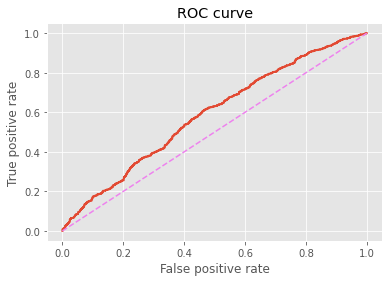

In [69]:
fpr, tpr, thresholds = roc_curve(y_val, knn.predict_proba(x_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("Train ROC AUC score = ", roc_auc_score(y_train, knn.predict_proba(x_train)[:,1]))
print("Test ROC AUC score = ", roc_auc_score(y_test, knn.predict_proba(x_test)[:,1]))
print("Validation ROC AUC score = ", roc_auc_score(y_val, knn.predict_proba(x_val)[:,1]))

In [44]:
lr = LogisticRegression(penalty='none')
lr.fit(x_train, y_train)

y_predict = lr.predict(x_val)
print('train accuracy: {}'.format(accuracy_score(y_val, y_predict)))
print('train precision: {}'.format(precision_score(y_val, y_predict)))
print('train recall: {}'.format(recall_score(y_val, y_predict)))
print('train f1: {}'.format(f1_score(y_val, y_predict)))
print('train fbeta: {}'.format(fbeta_score(y_val, y_predict, beta=1)), '\n')

train accuracy: 0.720499395892066
train precision: 0.7066365007541479
train recall: 0.7544283413848631
train f1: 0.7297507788161995
train fbeta: 0.7297507788161995 

average cross validation score: 0.809375


Train ROC AUC score =  0.8080770880810867
Test ROC AUC score =  0.854325053428161
Validation ROC AUC score =  0.799253497971222


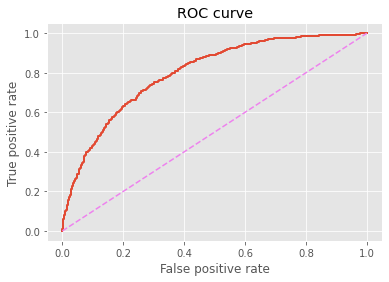

In [59]:
fpr, tpr, thresholds = roc_curve(y_val, lr.predict_proba(x_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("Train ROC AUC score = ", roc_auc_score(y_train, lr.predict_proba(x_train)[:,1]))
print("Test ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(x_test)[:,1]))
print("Validation ROC AUC score = ", roc_auc_score(y_val, lr.predict_proba(x_val)[:,1]))

In [46]:
dtc = DecisionTreeClassifier(min_samples_leaf=7, max_depth=13)
dtc.fit(x_train, y_train)

y_predict = dtc.predict(x_val)
print('train accuracy: {}'.format(accuracy_score(y_val, y_predict)))
print('train precision: {}'.format(precision_score(y_val, y_predict)))
print('train recall: {}'.format(recall_score(y_val, y_predict)))
print('train f1: {}'.format(f1_score(y_val, y_predict)))
print('train fbeta: {}'.format(fbeta_score(y_val, y_predict, beta=0.5)), '\n')

train accuracy: 0.6919049536850584
train precision: 0.71900826446281
train recall: 0.6304347826086957
train f1: 0.6718146718146718
train fbeta: 0.6993569131832797 

average cross validation score: 0.74825


Train ROC AUC score =  0.8484120757170931
Test ROC AUC score =  0.7677390518717638
Validation ROC AUC score =  0.7666415583505588


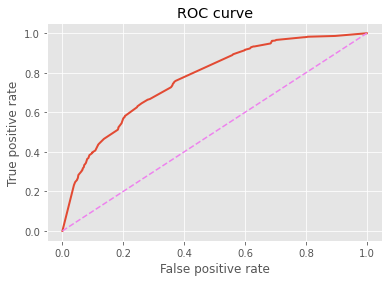

In [60]:
fpr, tpr, thresholds = roc_curve(y_val, dtc.predict_proba(x_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("Train ROC AUC score = ", roc_auc_score(y_train, dtc.predict_proba(x_train)[:,1]))
print("Test ROC AUC score = ", roc_auc_score(y_test, dtc.predict_proba(x_test)[:,1]))
print("Validation ROC AUC score = ", roc_auc_score(y_val, dtc.predict_proba(x_val)[:,1]))

In [31]:
rfc = RandomForestClassifier(n_estimators=100, max_features=10, max_depth=20)
rfc.fit(x_train, y_train)

y_predict = rfc.predict(x_val)
print('val accuracy: {}'.format(accuracy_score(y_val, y_predict)))
print('val precision: {}'.format(precision_score(y_val, y_predict)))
print('val recall: {}'.format(recall_score(y_val, y_predict)))
print('val f1: {}'.format(f1_score(y_val, y_predict)))
print('val fbeta: {}'.format(fbeta_score(y_val, y_predict, beta=1)), '\n')

train accuracy: 0.7757429060102622
train precision: 0.7930316107225611
train recall: 0.74624924984997
train f1: 0.7689295173707371
train fbeta: 0.7689295173707371 



In [44]:
f1_curve = 1/(1/recall_curve + 1/precision_curve)[1:]

In [51]:
threshold_curve[39920]

0.41594769254609176

In [48]:
np.argmax(f1_curve)

39920

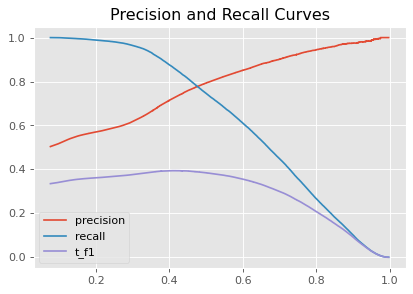

In [41]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, rfc.predict_proba(x_val)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
# plt.plot(recall_curve[1:], precision_curve[1:], label='p_r')
plt.plot(threshold_curve, f1_curve, label='t_f1')
plt.legend(loc='lower left');
plt.title('Precision and Recall Curves');

Train ROC AUC score =  0.909916481792252
Test ROC AUC score =  0.8863310939061646
Validation ROC AUC score =  0.8616755782291308


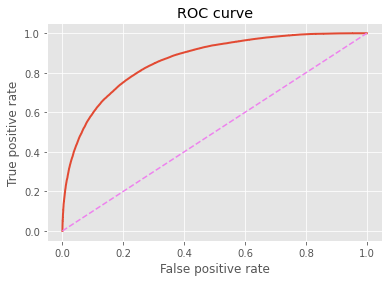

In [29]:
fpr, tpr, thresholds = roc_curve(y_val, rfc.predict_proba(x_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("Train ROC AUC score = ", roc_auc_score(y_train, rfc.predict_proba(x_train)[:,1]))
print("Test ROC AUC score = ", roc_auc_score(y_test, rfc.predict_proba(x_test)[:,1]))
print("Validation ROC AUC score = ", roc_auc_score(y_val, rfc.predict_proba(x_val)[:,1]))

In [104]:
# prediction test
x_row = x_val.iloc[0]
x_row = x_row.to_numpy()
x_row = x_row.reshape(1,106)
p1 = rfc.predict_proba(x_row)[:,1]

thresh_num = 0.41594769254609176

if p1 > thresh_num:
    predictY = 'win'
    print(predictY)
else:
    predictY = 'lose'
    print(predictY)
    
# [0, 1] = ['lose', 'win']

lose


In [50]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

y_predict = gnb.predict(x_val)
print('train accuracy: {}'.format(accuracy_score(y_val, y_predict)))
print('train precision: {}'.format(precision_score(y_val, y_predict)))
print('train recall: {}'.format(recall_score(y_val, y_predict)))
print('train f1: {}'.format(f1_score(y_val, y_predict)))
print('train fbeta: {}'.format(fbeta_score(y_val, y_predict, beta=1)), '\n')

train accuracy: 0.6516310914216673
train precision: 0.6514056224899598
train recall: 0.6529790660225443
train f1: 0.6521913952553277
train fbeta: 0.6521913952553277 

average cross validation score: 0.7027500000000001


Train ROC AUC score =  0.7117767077991975
Test ROC AUC score =  0.7240383727263171
Validation ROC AUC score =  0.6955516108898725


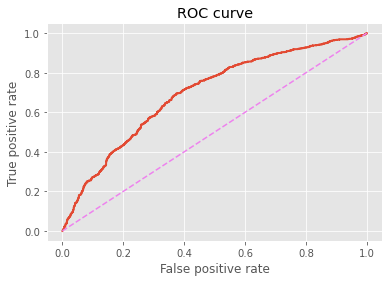

In [61]:
fpr, tpr, thresholds = roc_curve(y_val, gnb.predict_proba(x_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("Train ROC AUC score = ", roc_auc_score(y_train, gnb.predict_proba(x_train)[:,1]))
print("Test ROC AUC score = ", roc_auc_score(y_test, gnb.predict_proba(x_test)[:,1]))
print("Validation ROC AUC score = ", roc_auc_score(y_val, gnb.predict_proba(x_val)[:,1]))

In [52]:
svm_li = svm.LinearSVC(C=0.00001)
svm_li.fit(x_train_scaled, y_train)

y_predict = svm_li.predict(x_val)
print('train accuracy: {}'.format(accuracy_score(y_val, y_predict)))
print('train precision: {}'.format(precision_score(y_val, y_predict)))
print('train recall: {}'.format(recall_score(y_val, y_predict)))
print('train f1: {}'.format(f1_score(y_val, y_predict)))
print('train fbeta: {}'.format(fbeta_score(y_val, y_predict, beta=0.5)), '\n')

train accuracy: 0.500201369311317
train precision: 0.500201369311317
train recall: 1.0
train f1: 0.6668456375838926
train fbeta: 0.5557544299266154 

average cross validation score: 0.620125


Train ROC AUC score =  0.5
Test ROC AUC score =  0.5
Validation ROC AUC score =  0.5


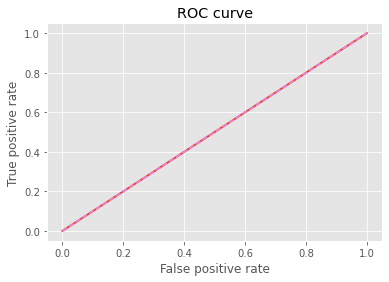

In [65]:
fpr, tpr, thresholds = roc_curve(y_val, svm_li.predict(x_val))

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("Train ROC AUC score = ", roc_auc_score(y_train, svm_li.predict(x_train)))
print("Test ROC AUC score = ", roc_auc_score(y_test, svm_li.predict(x_test)))
print("Validation ROC AUC score = ", roc_auc_score(y_val, svm_li.predict(x_val)))

In [105]:
import pickle

pickle.dump(rfc, open("my_pickled_model.p", "wb"))